<a href="https://colab.research.google.com/github/stevengregori92/Learn-ElasticNet/blob/main/Learn_ElasticNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install luwiji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Data

In [4]:
data = pd.read_csv('taxi_fare.csv', parse_dates=['pickup_datetime'])

pickup_dt = data.pickup_datetime.dt
data['year'] = pickup_dt.year
data['month'] = pickup_dt.month
data['day'] = pickup_dt.dayofweek
data['hour'] = pickup_dt.hour
data.drop(columns='pickup_datetime', inplace = True)

data['distance'] = np.abs(data.pickup_longitude - data.dropoff_latitude) + np.abs(data.pickup_latitude - data.dropoff_latitude)
data.drop(columns = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)

data.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,114.565630
1,16.9,1.0,2010,1,1,16,114.868753
2,5.7,2.0,2011,8,3,0,114.744008
3,7.7,1.0,2012,4,5,4,114.770171
4,5.3,1.0,2010,3,1,7,114.767611


#Dataset Splitting

In [5]:
X = data.drop(columns='fare_amount')
y = data.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15135, 6), (3784, 6), (15135,), (3784,))

#Training

In [6]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [7]:
rsp.enet_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [8]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform = 'yeo-johnson'), ['passenger_count', 'year', 'distance']),
    ('categoric', cat_pipe(encoder='onehot'),['month', 'day', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter = 100, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__alpha': 89.79855655182448, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.3042422429595378, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': True}
0.0 -0.00013327645909548083 -0.00031519250184630643


In [9]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

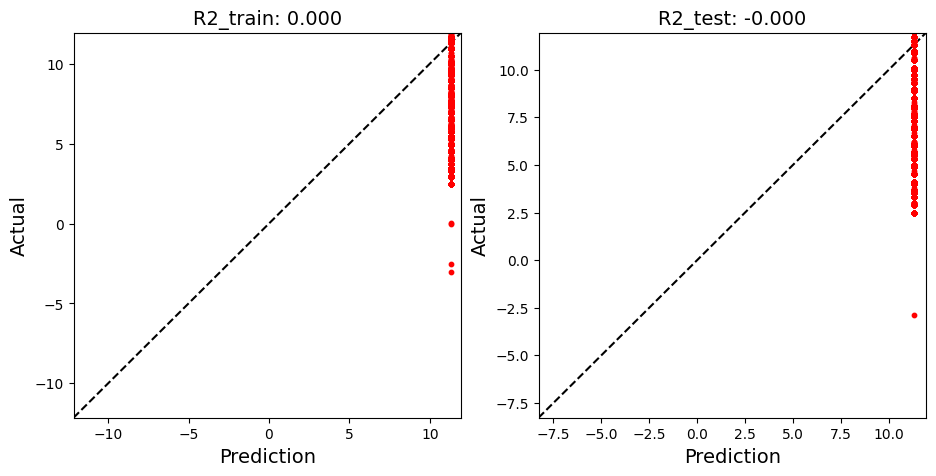

In [12]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

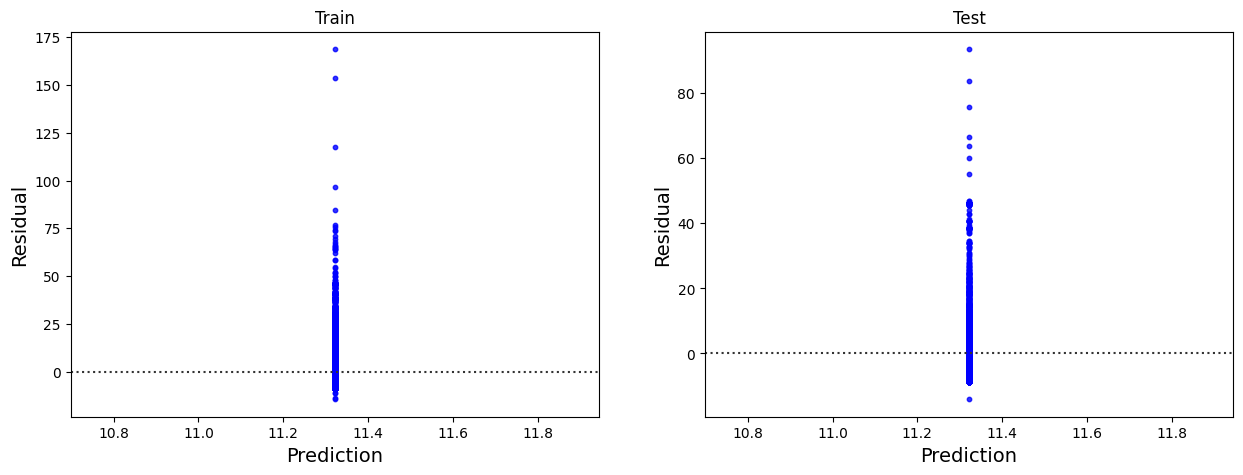

In [10]:
plot_residual(X_train, y_train, X_test, y_test, model)

In [11]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error
df_analysis.sort_values('error', ascending = False).head(10)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,114.929378,180.00,168.678424
1483,1.0,2009,8,4,21,114.666069,165.00,153.678424
6630,1.0,2014,5,4,1,0.000000,128.83,117.508424
14142,1.0,2014,12,4,10,114.785560,108.00,96.678424
12915,1.0,2011,9,2,1,114.453869,96.00,84.678424
9431,1.0,2014,4,4,14,114.733806,88.00,76.678424
10077,1.0,2009,11,0,14,114.638686,87.30,75.978424
4620,1.0,2012,8,1,20,114.731383,85.50,74.178424
18150,1.0,2011,12,3,22,114.814953,85.00,73.678424
14519,1.0,2011,12,4,14,114.761194,82.50,71.178424
